# LEXUS SUV Classifier
---

自動車の内装画像から車種名を特定する分類器の作成を目指します。<br>
ハンドルのLEXUSエンブレムが映った状態で、主にInstrumentPanel（以下、インパネと呼ぶ）の形状の特徴から車種を分類します。<br>
※仕向け(国内,海外）、RHD/LHD(右ハンドル/左ハンドル)、内装グレード（F-Sports,version-L)等の仕様毎の分類に関しては今回は除外します。<br>

以下の手順で行っていきます。<br>

1. ライブラリのインポート
2. 画像の読み込み
3. データ拡張
4. 前処理
5. モデリング
6. モデルのコンパイル
7. 学習＆評価
8. 予測結果の分析

## 1. ライブラリのインポート

In [2]:
import numpy as np
from keras.models import Sequential, model_from_json
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.utils import np_utils, to_categorical
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob, os
import re
import os
import pickle

## 2. 画像の読み込み

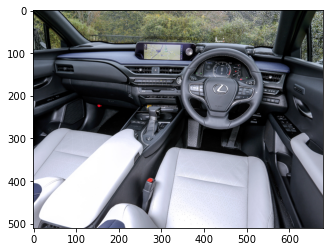

画素数とチャンネル数： (510, 680, 3)
[[[ 42  51  34]
  [ 33  44  28]
  [ 18  25  18]
  ...
  [ 98 102  87]
  [155 165 166]
  [134 148 148]]

 [[ 17  22  15]
  [ 41  49  38]
  [ 40  48  35]
  ...
  [135 131 128]
  [152 157 160]
  [154 163 170]]

 [[  0   1   0]
  [ 12  14  11]
  [ 34  42  31]
  ...
  [112 121 118]
  [200 208 221]
  [201 210 217]]

 ...

 [[159 160 178]
  [158 160 175]
  [157 158 176]
  ...
  [ 56  58  70]
  [ 55  57  69]
  [ 56  58  70]]

 [[162 161 179]
  [161 160 176]
  [157 158 176]
  ...
  [ 54  57  66]
  [ 54  57  66]
  [ 55  58  67]]

 [[161 160 178]
  [161 160 176]
  [157 158 176]
  ...
  [ 51  55  64]
  [ 53  56  65]
  [ 57  57  67]]]


In [3]:
from PIL import Image
# 画像読み込み
image = np.array(Image.open('../raw_UX/002.jpg'))
# 画像表示のためにmatplotlibを利用　　　　　
import matplotlib.pyplot as plt      
# 原画像の表示
plt.imshow( image )
plt.show()
# 出力される
print("画素数とチャンネル数：",image.shape)
# 画像のデータ
print(image)

## 3. データ拡張
UX NX RXのオリジナル画像150枚ずつが入ったディレクトリを用意し、kerasのImageDataGeneratorを利用してデータの水増しを行っています。<br>
LEXUSエンブレムが読み取れる用、horizontal_flip,vertical_flip等は適用しておりません。<br>
又、画像サイズが小さいと肝心のインパネ部分が見切れる為、画像サイズを255×255にリサイズして画像を生成しています。<br>

In [7]:
#関数化
def image_generate(input_dir,output_dir):
 
    """
    ImageDateGeneratorで画像の水増しを行い、フォルダ内に画像を格納していく

    Parameters:
    ----------
    input_dir : ディレクトリパス（入力）
    
    output_dir：ディレクトリパス（出力）

    
    Returns
    -------
    image：水増し後の画像

    """

    #入力ディレクトリを作成
    input_dir1 = input_dir
    files = glob.glob(input_dir1 + '/*.jpg')
 
    # 出力ディレクトリを作成
    output_dir1 = output_dir
    if os.path.isdir(output_dir1) == False:
        os.mkdir(output_dir1)
 
 
    for i, file in enumerate(files):
        img = load_img(file)
        img = img.resize((255, 255))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
 
        datagen = ImageDataGenerator(
               width_shift_range=0.2,#ランダムに水平方向に平行移動
               height_shift_range=0.2,#ランダムに垂直方向に平行移動
               shear_range=0.5,#せん断の度合い
               zoom_range=0.2,# ランダムに画像を圧縮、拡大 
               horizontal_flip=False,
               vertical_flip=False,
               )
 
        # オリジナル画像1枚に対し、20個の画像を生成します
        g = datagen.flow(x, batch_size=1, save_to_dir=output_dir1, save_prefix='img', save_format='jpg')
        for i in range(20):
            batch = g.next()
            
    return image

In [8]:
image_generate("../raw_UX","../processing_UX")
image_generate("../raw_NX","../processing_NX")
image_generate("../raw_RX","../processing_RX")

array([[[ 42,  51,  34],
        [ 33,  44,  28],
        [ 18,  25,  18],
        ...,
        [ 98, 102,  87],
        [155, 165, 166],
        [134, 148, 148]],

       [[ 17,  22,  15],
        [ 41,  49,  38],
        [ 40,  48,  35],
        ...,
        [135, 131, 128],
        [152, 157, 160],
        [154, 163, 170]],

       [[  0,   1,   0],
        [ 12,  14,  11],
        [ 34,  42,  31],
        ...,
        [112, 121, 118],
        [200, 208, 221],
        [201, 210, 217]],

       ...,

       [[159, 160, 178],
        [158, 160, 175],
        [157, 158, 176],
        ...,
        [ 56,  58,  70],
        [ 55,  57,  69],
        [ 56,  58,  70]],

       [[162, 161, 179],
        [161, 160, 176],
        [157, 158, 176],
        ...,
        [ 54,  57,  66],
        [ 54,  57,  66],
        [ 55,  58,  67]],

       [[161, 160, 178],
        [161, 160, 176],
        [157, 158, 176],
        ...,
        [ 51,  55,  64],
        [ 53,  56,  65],
        [ 57,  57,  67]]

ディレクトリ内の画像数確認

データ水増し後の枚数をそれぞれ確認します。<br>

In [11]:
# ファイル数を調べたいフォルダのパス
path0 = "../processing_UX" 
path1 = "../processing_NX" 
path2 = "../processing_RX" 
 
# フォルダ内の全ファイル名をリスト化
files0 = os.listdir(path0)
files1 = os.listdir(path1)
files2 = os.listdir(path2)
 
# リストの長さ（ファイル数）を取得
count0 = len(files0)
count1 = len(files1)
count2 = len(files2)
 
# ファイル数を確認
print(count0)
print(count1)
print(count2)

2598
2572
2598



## 4. 前処理
学習用データと検証用データに分割し、学習に適した形にデータを成形します。<br>

In [12]:
# 画像を読み込んで、行列に変換する関数を定義
def img_to_traindata(file, img_rows, img_cols, rgb):
    if rgb == 0:
        img = load_img(file, color_mode = "grayscale", target_size=(img_rows,img_cols)) # grayscaleで読み込み
    else:
        img = load_img(file, color_mode = "rgb", target_size=(img_rows,img_cols)) # RGBで読み込み
    x = img_to_array(img)
    x = x.astype('float32')
    x /= 255
    return x


img_rows = 255 
img_cols = 255 
num_classes = 3 # UX,NX,RXの3クラス
dropout_rate = 0.5
img_dirs = ["../processing_UX", "../processing_NX", "../processing_RX"] # UX,NX,RXの加工後の画像を格納したディレクトリ

X = []
Y = []

#ディレクトリ内の画像ファイルを全て読み込み、空のリストX,Yに画像とラベルを順番に格納
for n, img_dir in enumerate(img_dirs):
    img_files = glob.glob(img_dir+"/*.jpg")   
    for i, img_file in enumerate(img_files):  
        x = img_to_traindata(img_file, img_rows, img_cols, 1) 
        X.append(x)
        Y.append(n)

In [13]:
 # NumPy配列に変換
X = np.asarray(X)
Y = np.asarray(Y)

# 学習用データとテストデータに分割
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0 )

# 学習データはfloat32型に変換し、正規化(0～1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

In [14]:
# 正解ラベルをone hotエンコーディング
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [15]:
# 作成したデータの型を表示
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(6214, 255, 255, 3)
(6214, 3)
(1554, 255, 255, 3)
(1554, 3)


## 5. モデリング

モデルはMaxPooling層を伴う4つの畳み込みブロックからなるシンプルな畳み込みニューラルネットワークです。<br>
UX、NX、RXを見分ける3クラス分類なので、最終ユニット数3つ、分類問題なので活性化関数はsoftmax関数を使用し、クラスに属する確率を出力します。<br>
過学習を抑制する工夫として、dropout層を追加しています。<br>

In [16]:
from keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation="relu",input_shape=(255,255,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5)) 
model.add(layers.Dense(512,activation="relu"))
model.add(layers.Dense(num_classes,activation="softmax"))

## 6. モデルのコンパイル

RMSpropオプティマイザーと categorical_crossentropy 損失関数を選択します。<br>
各学習エポックの学習と検証の精度を表示するために、metrics 引数を渡します。<br>

In [17]:
from keras import optimizers

model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=["acc"])

In [18]:
# モデル構造の表示
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 253, 253, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 128)      

## 7. 学習＆評価

In [19]:
history = model.fit(x_train, 
                    y_train, 
                    batch_size=5,
                    epochs=20, 
                    verbose=1, # verbose=1:標準出力にログを表示
                    validation_split=0.1)

# テスト用データセットで学習済分類器に入力し、パフォーマンスを計測
score = model.evaluate(x_test, 
                        y_test,
                        verbose=0
                        )

# パフォーマンス計測の結果を表示
# 損失値（値が小さいほど良い）
print('Test loss:', score[0])

# 正答率（値が大きいほど良い）
print('Test accuracy:', score[1])


Train on 5592 samples, validate on 622 samples
Epoch 1/20
5592/5592 [==============================] - 799s 143ms/step - loss: 1.0991 - acc: 0.3326 - val_loss: 1.0995 - val_acc: 0.3167
Epoch 2/20
5592/5592 [==============================] - 794s 142ms/step - loss: 1.0928 - acc: 0.3687 - val_loss: 1.0654 - val_acc: 0.4469
Epoch 3/20
5592/5592 [==============================] - 818s 146ms/step - loss: 1.0434 - acc: 0.4551 - val_loss: 0.9982 - val_acc: 0.5000
Epoch 4/20
5592/5592 [==============================] - 816s 146ms/step - loss: 0.9816 - acc: 0.5175 - val_loss: 1.0205 - val_acc: 0.4887
Epoch 5/20
5592/5592 [==============================] - 823s 147ms/step - loss: 0.8666 - acc: 0.6014 - val_loss: 0.8248 - val_acc: 0.6125
Epoch 6/20
5592/5592 [==============================] - 810s 145ms/step - loss: 0.7468 - acc: 0.6688 - val_loss: 0.7240 - val_acc: 0.6640
Epoch 7/20
5592/5592 [==============================] - 808s 144ms/step - loss: 0.6647 - acc: 0.7196 - val_loss: 0.7283 - va

## 8. 予測結果の分析
学習過程をグラフにプロットします。

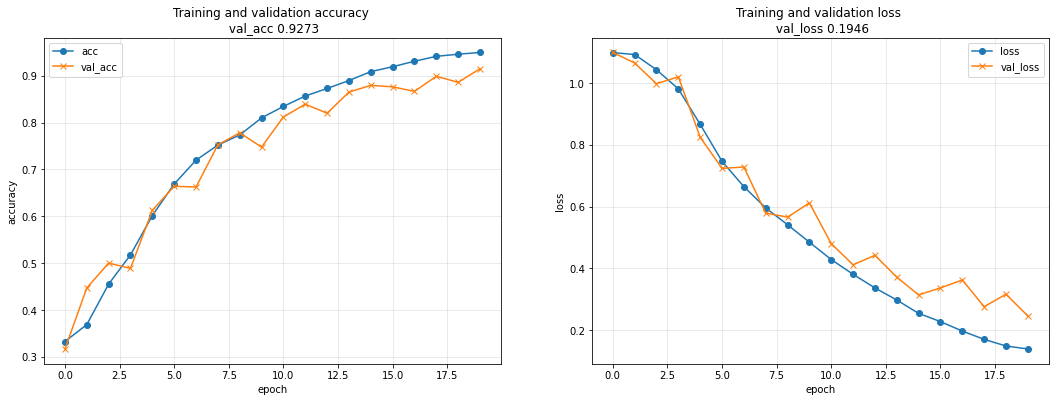

In [20]:
fig = plt.figure(figsize=(18, 6))  # ウィンドウ作成

# 正解率グラフ
plt.subplot(1, 2, 1)  # 2つ横に並べて右側に表示
plt.plot(history.history['acc'], label='acc', ls='-', marker='o')  # 学習用データのaccuracy
plt.plot(history.history['val_acc'], label='val_acc', ls='-', marker='x')  # 訓練用データのaccuracy
plt.title(f'Training and validation accuracy \n val_acc {score[1]:.4f}')  # タイトル
plt.xlabel('epoch')  # 横軸
plt.ylabel('accuracy')  # 縦軸
plt.legend(['acc', 'val_acc'])  # 凡例
plt.grid(color='gray', alpha=0.2)  # グリッド表示

# 損失グラフ
plt.subplot(1, 2, 2)  # 2つ横に並べて左側に表示
plt.plot(
    history.history['loss'], label='loss', ls='-', marker='o')  # 学習用データのloss
plt.plot(history.history['val_loss'], label='val_loss', ls='-', marker='x')  # 訓練用データのloss
plt.title(f'Training and validation loss \n val_loss {score[0]:.4f}')#タイトル
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.grid(color='gray', alpha=0.2)

# 保存
plt.savefig('1.png')

plt.show()

未知のデータに対して作成した分類器を使用して、画像を正しく分類出来るかを確認します。<br>
試しに、Unknown_imageというディレクトリの中に新たな画像を用意し、分類を行ってみます。

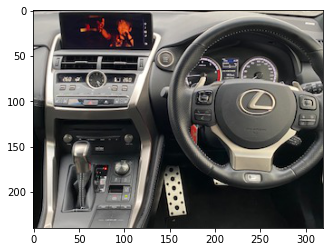

In [29]:
###用意した画像を表示
image = np.array(Image.open('../Unknown_image/sample.jpg'))
# 画像表示のためにmatplotlibを利用　　　　　
import matplotlib.pyplot as plt      
# 原画像の表示
plt.imshow( image )
plt.show()

In [30]:
input_dir = "../Unknown_image"
files = glob.glob(input_dir + '/*.jpg')

for i, file in enumerate(files):
 
    img = load_img(file)
    img = img.resize((255, 255))
    x = img_to_array(img)
    x = x / 255
    x = np.expand_dims(x, axis=0)
    
    pred = model.predict(x)
    pred_class = np.argmax(pred[0])
    if pred_class == 0:
        print("識別結果:","UX")
    elif pred_class == 1:
        print("識別結果:","NX")
    else:
        print("識別結果:","RX")

識別結果: NX


グラフから分かるように、epoch数が上がると過学習気味になっています。<br>
今後、学習データの枚数を増やしたり、モデル構造の見直しをすることで更なる精度向上が見込めるものと思います。<br>
